In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import FOLPSD as FOLPS

#### Inputs

Fix *cosmological* and *nuisance parameters*. Upload the corresponding linear power spectrum. You can also compute it using an Einstein-Boltzmann code like **CAMB**, **CLASS**, etc. 

Cosmological parameters:

Define a vector with the cosmological parameters, CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]

In [5]:
#omega_i = Omega_i h² 
omega_b = 0.02242;        #baryons
omega_cdm = 0.117;       #CDM
omega_ncdm = 0.0;    #massive neutrinos 
h = 0.67;                 #h = H0/100
z_pk = 0.57;                 #evaluation redshift
CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]

Linear power spectrum at redshift z_pk:

In [8]:
inputpkT = np.loadtxt('pk_linear_simtocmass.txt', unpack = True)

Nuisance parameters for the linear power spectrum:

Define a vector with the nuisances parameters, NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP]

In [11]:
#bias parameters
b1 = 1.9;                 
b2= 8/21*(b1-1)
bs2= -4/7*(b1-1)      
b3nl = 32/315*(b1 - 1);  

#EFT parameters
alpha0, alpha2, alpha4 = 0,0,0    # PEFT(k) = (alpha0 + alpha2*mu^2+ alpha4*mu^4)  k^2 Plin(k)
ctilde = 0               #NLO counterterm
X_FoG = 0  # uses a Lorentzian Damping 1/(1+x^2), with x = X_FoG f sigma_v mu. 

#Stochatics parameters
# Noise is Pshot = PshotP * ( alphashot0 + alphashot2*(k*mu)**2 )
alphashot0 = 0;          
alphashot2 = 0;            
PshotP = 0    # =1/barn.  Poissonian shot noise
NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP,X_FoG]

#### Computation of $M$ matrices 
**They do not depend on the cosmology**, so they are **computed only one time**. That is, the first time the code is called, it computes the $M$ matrices and stores them for the rest of the runs, which can be of the order of thousands in parameter estimations.

In [14]:
matrices = FOLPS.Matrices()

N = 128 sampling points
M matrices have been computed


In [16]:
## AP
Omfid = -1  # for AP set > 0
APtrue = False
if Omfid > 0:
    APtrue = True
    
if z_pk < 0.0000000000001:
    APtrue = False
    Omfid = -1    

In [18]:
# output k_ev
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 100) # array of k_ev in [h/Mpc]

In [20]:
# Compute 1loop integrals
nonlinear = FOLPS.NonLinear(inputpkT, CosmoParams)
kh, pkl0, pkl2, pkl4 = FOLPS.RSDmultipoles(k_ev, NuisanParams, Omfid = Omfid, AP=APtrue)

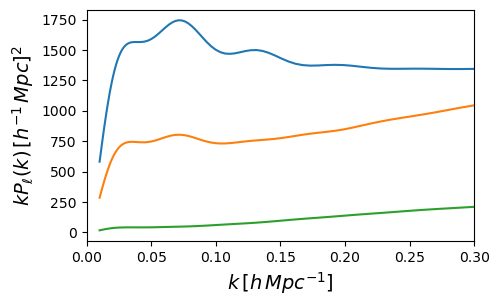

In [22]:
fig, axs = plt.subplots(figsize=(5,3))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k P_{\ell}(k) \, [h^{-1} \,  Mpc]^2$', fontsize =  14)

axs.plot(kh, kh * pkl0, label=r'$\ell = 0$')
axs.plot(kh, kh * pkl2, label=r'$\ell = 2$')
axs.plot(kh, kh * pkl4, label=r'$\ell = 4$')

axs.set_xlim([0, 0.3])
plt.show()


# Run Bispectrum in Sugiyama basis

In [25]:
# niusance parameters for the bispectrum
Pshot = 0; # This would be the same as PshopP*alphashot0 if the bispectrum were computed up to 1loop (I think!)
Bshot = 0;
c1,c2=-40,0
X_FoG_bk=0

bisp_nuis_params = [b1, b2, bs2, c1,c2,Pshot,Bshot, X_FoG_bk]
bisp_cosmo_params = [(omega_cdm+omega_b+omega_ncdm)/h**2,h]

In [27]:
k_ev = np.linspace(0.01,0.2, num = 40) 
k_ev_bk=np.vstack([k_ev,k_ev]).T   # List of pairs of k. (B=B(k1,k2))
precision=[10,10,10]

In [29]:
%%time
k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[1][1]])
B000, B110, B220, B202, B112, B404 = FOLPS.Bisp_Sugiyama_all(bisp_cosmo_params, bisp_nuis_params,
                                   k_pkl_pklnw=k_pkl_pklnw, z_pk=z_pk, k1k2pairs=k_ev_bk,
                                   Omfid=Omfid,precision=precision)

CPU times: user 52.9 ms, sys: 3.09 ms, total: 55.9 ms
Wall time: 54 ms


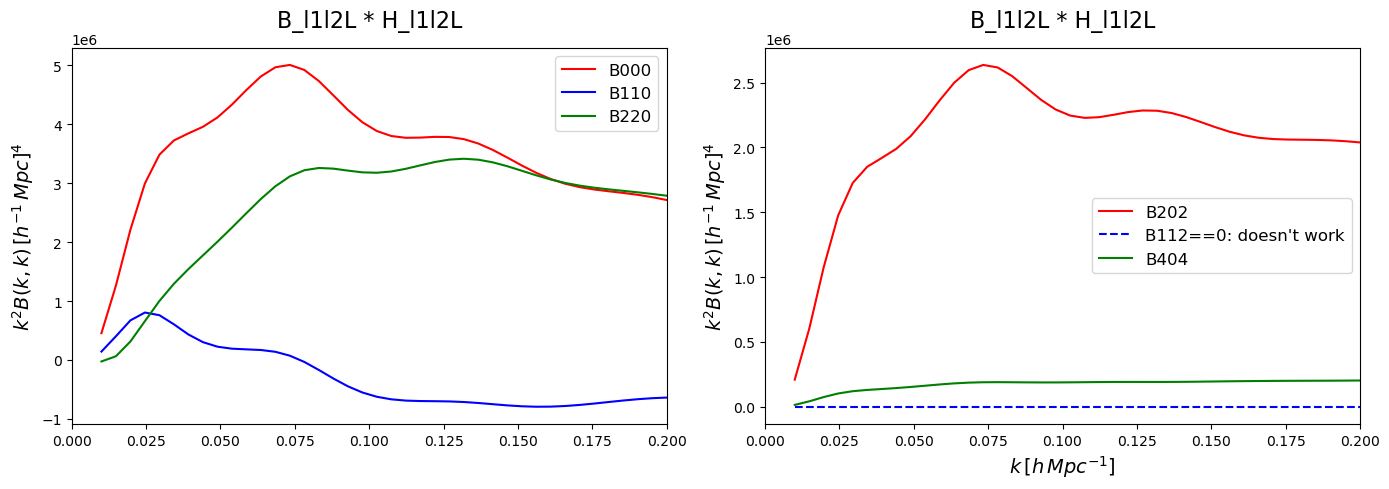

In [31]:
xmax=0.2

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[0].plot(k_ev, k_ev**2 * B000, label=r'B000', ls='-', color='red')
axs[0].plot(k_ev, k_ev**2 * B110, label=r'B110', ls='-', color='blue')
axs[0].plot(k_ev, k_ev**2 * B220, label=r'B220', ls='-', color='green')
axs[0].set_xlim([0, xmax])
axs[0].legend(fontsize=12, loc='best')
axs[0].set_title('B_l1l2L * H_l1l2L', fontsize=16, pad=15)

axs[1].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize=14)
axs[1].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[1].plot(k_ev, k_ev**2 * B202, label=r'B202', ls='-', color='red')
axs[1].plot(k_ev, k_ev**2 * B112, label=r"B112==0: doesn't work", ls='--', color='blue')
axs[1].plot(k_ev, k_ev**2 * B404, label=r'B404', ls='-', color='green')
axs[1].set_xlim([0, xmax])
axs[1].legend(fontsize=12, loc='best')
axs[1].set_title('B_l1l2L * H_l1l2L', fontsize=16, pad=15)


plt.tight_layout()
plt.show()

(Note B112 is not yet implemented)

In the above plot, we are rescaling the multipoles by the factors: 

H202 =  1/np.sqrt(5)
H110 = -1/np.sqrt(3)
H220 =  1/np.sqrt(5)
H112 =  np.sqrt(2.0/15.0)
H404 =  1.0/3.0

in this way we can match Fig.3 of Sugiyama et al 1803.02132.   

We can keep the "correct" normalization factors by adding the argument renormalize=False:

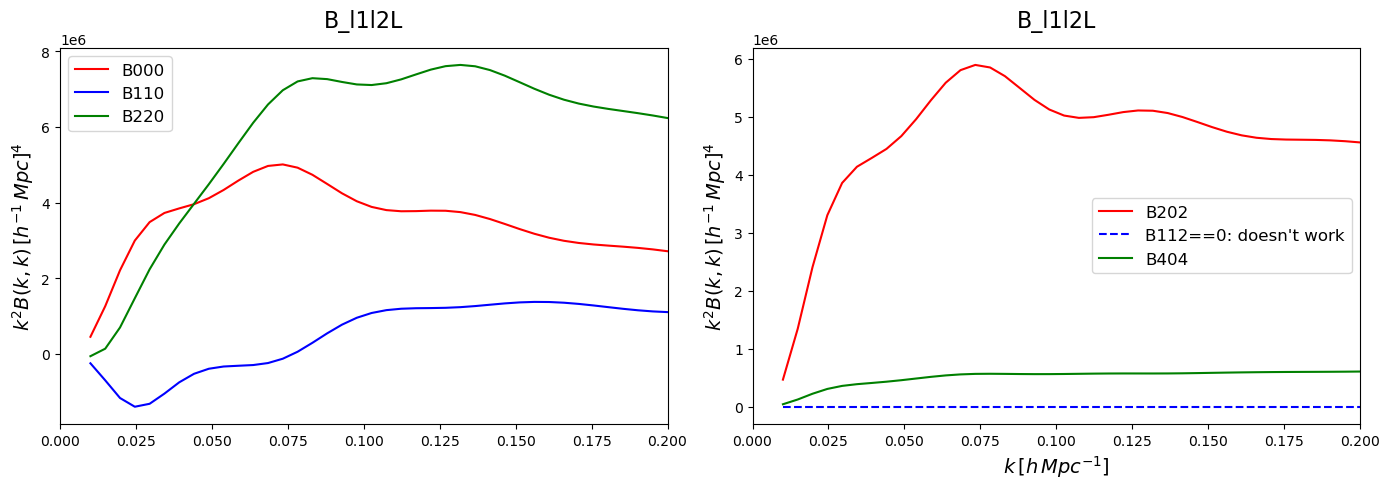

In [34]:

k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[1][1]])
B000_c, B110_c, B220_c, B202_c, B112_c, B404_c = FOLPS.Bisp_Sugiyama_all(bisp_cosmo_params, bisp_nuis_params,
                                   k_pkl_pklnw=k_pkl_pklnw, z_pk=z_pk, k1k2pairs=k_ev_bk,
                                   Omfid=Omfid,precision=precision,renormalize=False)

xmax=0.2

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[0].plot(k_ev, k_ev**2 * B000_c, label=r'B000', ls='-', color='red')
axs[0].plot(k_ev, k_ev**2 * B110_c, label=r'B110', ls='-', color='blue')
axs[0].plot(k_ev, k_ev**2 * B220_c, label=r'B220', ls='-', color='green')
axs[0].set_xlim([0, xmax])
axs[0].legend(fontsize=12, loc='best')
axs[0].set_title('B_l1l2L', fontsize=16, pad=15)

axs[1].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize=14)
axs[1].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[1].plot(k_ev, k_ev**2 * B202_c, label=r'B202', ls='-', color='red')
axs[1].plot(k_ev, k_ev**2 * B112_c, label=r"B112==0: doesn't work", ls='--', color='blue')
axs[1].plot(k_ev, k_ev**2 * B404_c, label=r'B404', ls='-', color='green')
axs[1].set_xlim([0, xmax])
axs[1].legend(fontsize=12, loc='best')
axs[1].set_title('B_l1l2L', fontsize=16, pad=15)


plt.tight_layout()
plt.show()

### precision

In [37]:
%%time
## The precision can be changed at the cost of being much slower. 
## The plot below shows that the difference is only about 0.5% at k=0.15
B000_mp, B110_mp, B220_mp, B202_mp, B112_mp, B404_mp = FOLPS.Bisp_Sugiyama_all(bisp_cosmo_params, bisp_nuis_params,
                                   k_pkl_pklnw=k_pkl_pklnw, z_pk=z_pk, k1k2pairs=k_ev_bk,
                                   Omfid=Omfid,precision=[32,32,32])

CPU times: user 329 ms, sys: 16.1 ms, total: 345 ms
Wall time: 344 ms


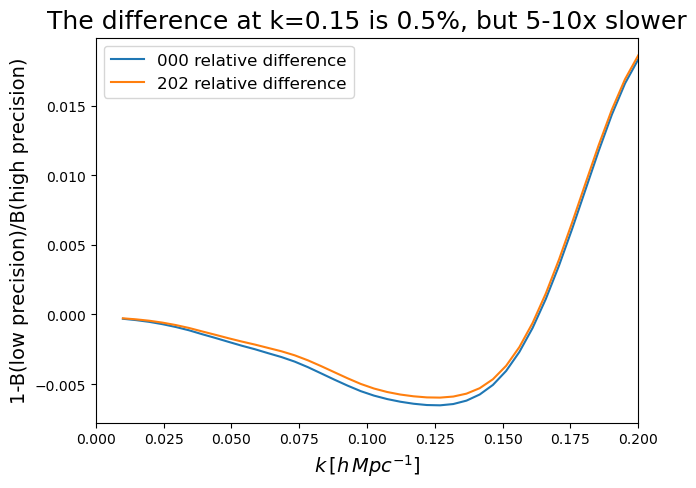

In [39]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'1-B(low precision)/B(high precision)', fontsize =  14)

axs.plot(k_ev, 1-B000/B000_mp, label=r'000 relative difference')
axs.plot(k_ev, 1-B202/B202_mp, label=r'202 relative difference')
axs.legend(fontsize=12, loc='best')
axs.set_title('The difference at k=0.15 is 0.5%, but 5-10x slower', fontsize=18, pad=7)

axs.set_xlim([0, 0.2])
plt.show()


### running B000 and B202 only 

it is only a little bit faster

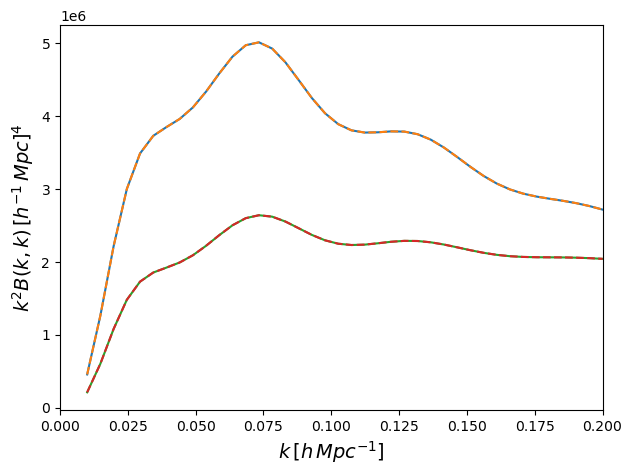

In [42]:
k_pkl_pklnw=np.array([nonlinear[0][0], nonlinear[0][1], nonlinear[1][1]])
B000_, B202_ = FOLPS.Bisp_Sugiyama(bisp_cosmo_params, bisp_nuis_params,
                                   k_pkl_pklnw=k_pkl_pklnw, z_pk=z_pk, k1k2pairs=k_ev_bk,
                                   Omfid=Omfid,precision=[10,10,10])

fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize =  14)

axs.plot(k_ev, k_ev**2 * B000_, label=r'B000')
axs.plot(k_ev, k_ev**2 * B000, label=r'B000',ls='--')
axs.plot(k_ev, k_ev**2 * B202_,label=r'B202')
axs.plot(k_ev, k_ev**2 * B202,label=r'B202',ls='--')

axs.set_xlim([0, 0.20])
plt.show()